In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from stable_baselines3 import DQN, DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback

from alphaQ.utils import download_ticker_data, train_test_split, plot_episodes
from alphaQ.env import PortfolioEnv
from alphaQ.env2 import PortfolioEnvOld
from alphaQ.agent.features import FeatureExtractor
from alphaQ.agent.utils import AgentStrategy
from alphaQ.eval import evalu8, evaluate_baselines

import config
from config import TICKERS, MODEL, MODELS

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (18, 9)

In [18]:
# TICKERS = ['AXP', 'GE', 'INTC', 'NKE']

In [4]:
data = download_ticker_data(TICKERS, start=config.START, end=config.END, columns=['Open', 'High', 'Low', 'Close']).dropna()
train, val, test = train_test_split(data, train_years=10)

market = download_ticker_data('^DJI', start=config.START, end=config.END, columns=['Open', 'High', 'Low', 'Close']).loc[data.index]
market_train, market_val, market_test = train_test_split(market, train_years=10)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
train.shape, val.shape, test.shape

((2520, 16), (423, 16), (423, 16))

In [6]:
market_train.shape, market_val.shape, market_test.shape

((2520, 4), (423, 4), (423, 4))

In [11]:
action_space_type = config.ACTION_SPACE[MODEL]

env = PortfolioEnv(
    tickers=TICKERS,
    prices=train, 
    market_prices=market_train,
    window_length=config.WINDOW_LENGTH,
    trading_cost=config.COMMISSION_RATE,
    action_space_type=action_space_type
)

val_env = PortfolioEnvOld(
    tickers=TICKERS,
    prices=val, 
    market_prices=market_val,
    window_length=config.WINDOW_LENGTH,
    trading_cost=config.COMMISSION_RATE,
    action_space_type=action_space_type,
    test_env=True
)

### DQN

In [ ]:
# TODO

### DDPG

In [9]:
policy_kwargs = dict(
    features_extractor_class=FeatureExtractor,
    features_extractor_kwargs=dict(features_dim=(32+1)*4+1),
    net_arch=[512, 256, 128],
    # optimizer_kwargs=dict(weight_decay=5e-9)
)

In [10]:
if config.ACTION_NOISE:
    
    n_actions = env.action_space.shape[-1]

    action_noise = config.NOISE[config.ACTION_NOISE](
        mean=np.zeros(n_actions), 
        sigma=config.NOISE_SIGMA * np.ones(n_actions))

else:
    action_noise = None

In [11]:
agent = DDPG(
    policy=config.POLICY, 
    env=env,
    learning_rate=config.ALPHA,
    learning_starts=config.TRAIN_START,
    batch_size=config.BATCH_SIZE, 
    buffer_size=config.BUFFER_SIZE, 
    tau=config.TAU,
    gamma=config.GAMMA,
    train_freq=config.TRAIN_FREQ,
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,
    verbose=config.TRAIN_VERBOSE_LEVEL, 
    seed=config.RANDOM_SEED
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Train

In [26]:
episode_length = env._prices.shape[0] - config.WINDOW_LENGTH + 1

if config.CALLBACK_ENABLED:
    
    eval_callback = EvalCallback(
        eval_env=val_env, 
        n_eval_episodes=1, 
        eval_freq=episode_length, 
        log_path=config.LOG_PATH, 
        best_model_save_path=config.SAVE_PATH, 
        verbose=config.CALLBACK_VERBOSE_LEVEL, 
        warn=False
    )

else:
    eval_callback = None

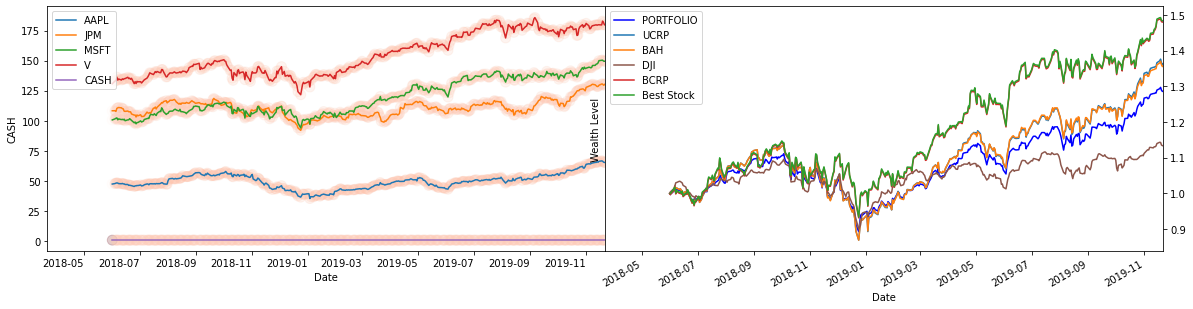

Eval num_timesteps=2471, episode_reward=0.27 +/- 0.00
Episode length: 373.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 373      |
|    mean_reward     | 0.271    |
| time/              |          |
|    total timesteps | 2471     |
---------------------------------
New best mean reward!


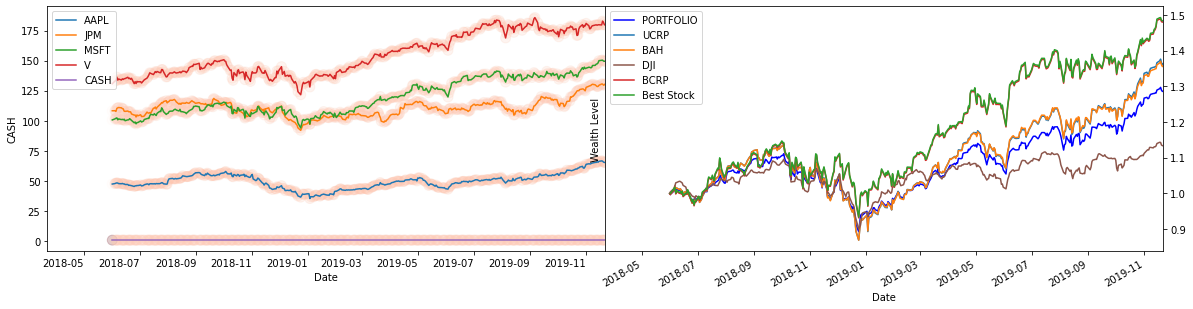

Eval num_timesteps=4942, episode_reward=0.27 +/- 0.00
Episode length: 373.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 373      |
|    mean_reward     | 0.271    |
| time/              |          |
|    total timesteps | 4942     |
---------------------------------


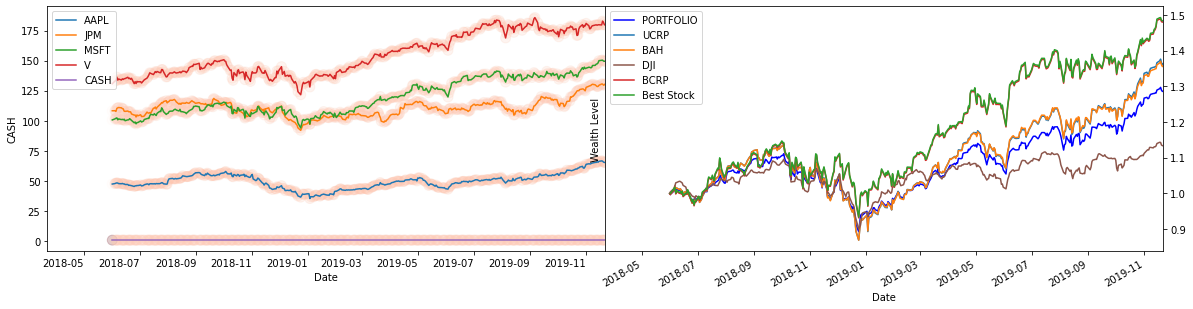

Eval num_timesteps=7413, episode_reward=0.27 +/- 0.00
Episode length: 373.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 373      |
|    mean_reward     | 0.271    |
| time/              |          |
|    total timesteps | 7413     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.47e+03 |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 339      |
|    time_elapsed    | 29       |
|    total timesteps | 9880     |
---------------------------------


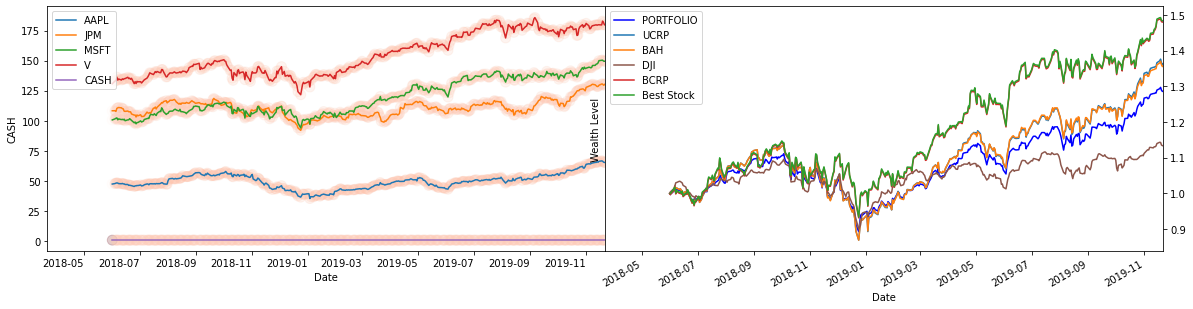

Eval num_timesteps=9884, episode_reward=0.27 +/- 0.00
Episode length: 373.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 373      |
|    mean_reward     | 0.271    |
| time/              |          |
|    total timesteps | 9884     |
---------------------------------


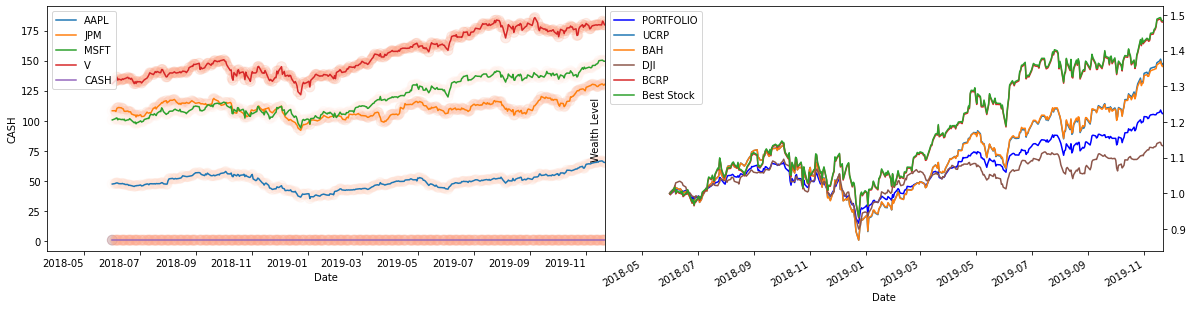

Eval num_timesteps=12355, episode_reward=0.22 +/- 0.00
Episode length: 373.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 373      |
|    mean_reward     | 0.215    |
| time/              |          |
|    total timesteps | 12355    |
| train/             |          |
|    actor_loss      | -0.00577 |
|    critic_loss     | 0.000162 |
|    learning_rate   | 2e-06    |
|    n_updates       | 2518     |
---------------------------------


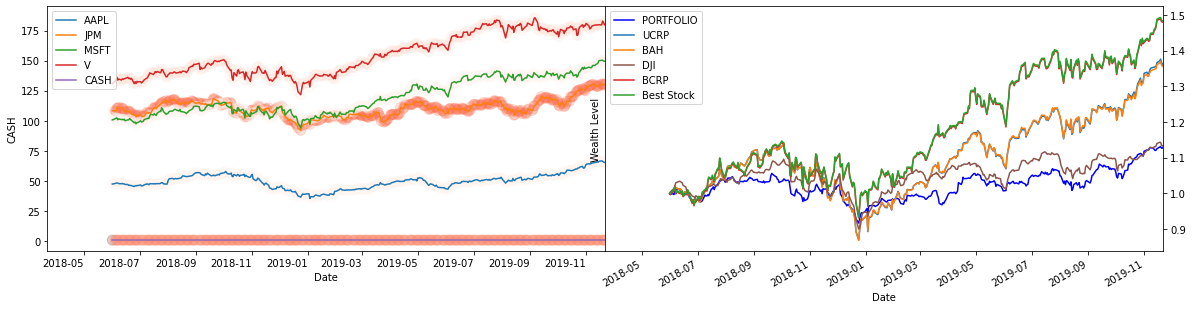

Eval num_timesteps=14826, episode_reward=0.13 +/- 0.00
Episode length: 373.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 373      |
|    mean_reward     | 0.132    |
| time/              |          |
|    total timesteps | 14826    |
| train/             |          |
|    actor_loss      | -0.0065  |
|    critic_loss     | 0.00014  |
|    learning_rate   | 2e-06    |
|    n_updates       | 5018     |
---------------------------------


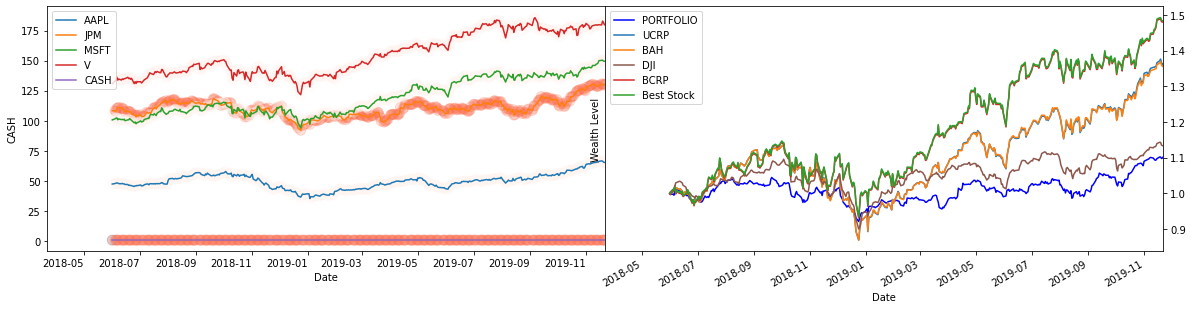

Eval num_timesteps=17297, episode_reward=0.11 +/- 0.00
Episode length: 373.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 373      |
|    mean_reward     | 0.106    |
| time/              |          |
|    total timesteps | 17297    |
| train/             |          |
|    actor_loss      | -0.00328 |
|    critic_loss     | 0.000146 |
|    learning_rate   | 2e-06    |
|    n_updates       | 7418     |
---------------------------------


KeyboardInterrupt: 

In [27]:
agent.learn(total_timesteps=10*episode_length, callback=eval_callback)

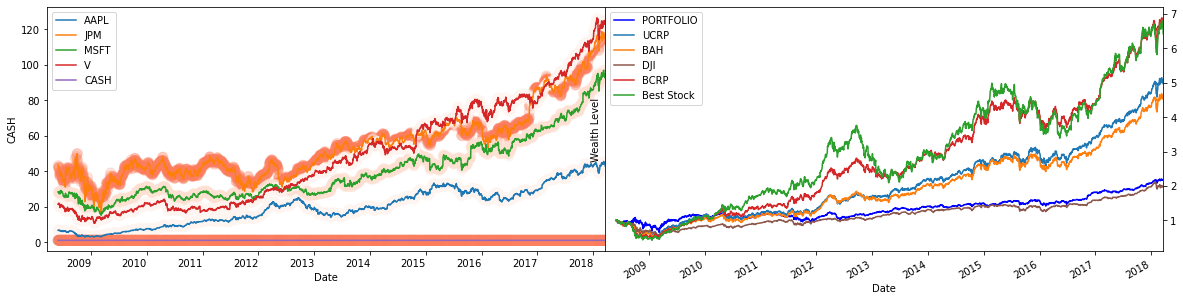

In [65]:
env.render()

mean:
rewards        -0.654770
total_wealth    0.884007
dtype: float64


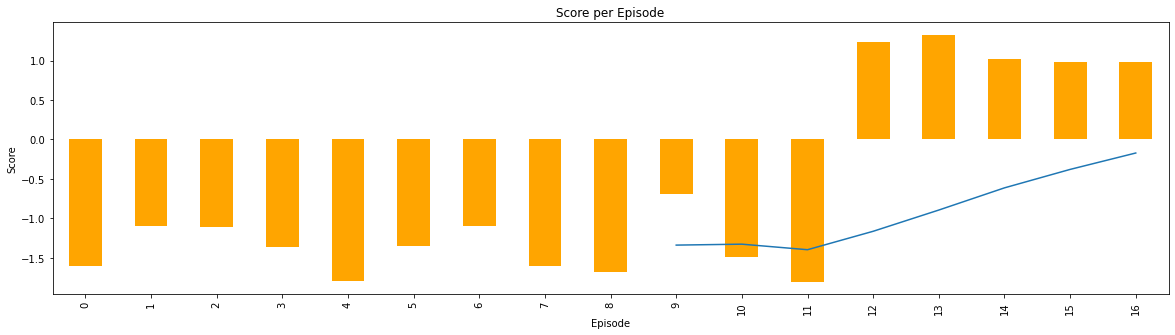

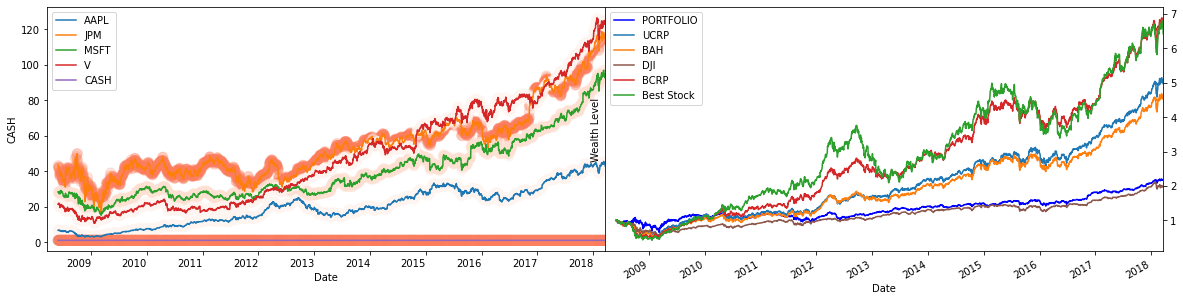

In [68]:
plot_episodes(env)

env.render()

Average:
 rewards         0.233134
total_wealth    1.244557
dtype: float64


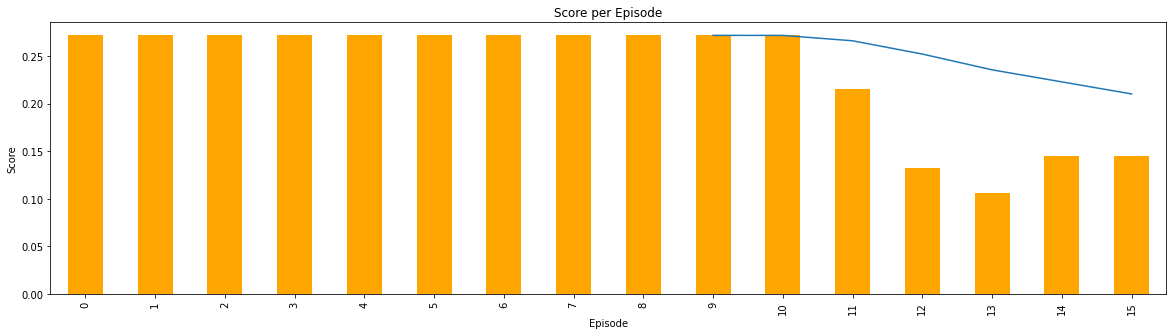

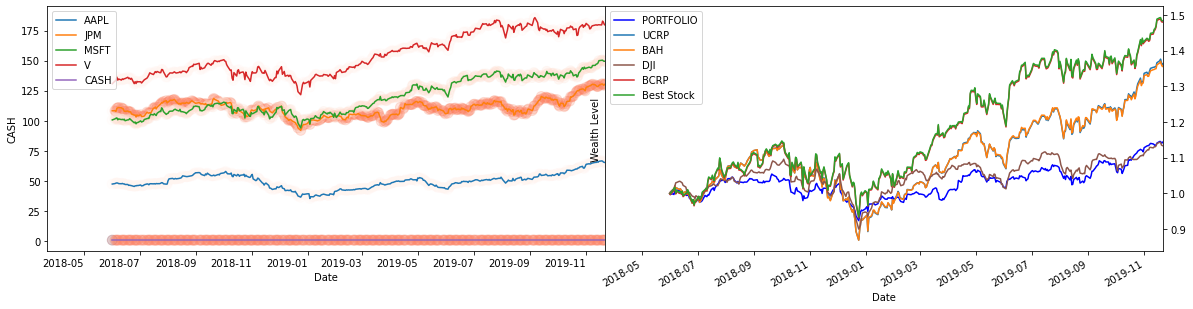

In [66]:
plot_episodes(val_env)

val_env.render()

### Test

In [58]:
action_space_type = config.ACTION_SPACE[MODEL]

test_env = PortfolioEnv(
    tickers=TICKERS,
    prices=test, 
    market_prices=market_test,
    window_length=config.WINDOW_LENGTH,
    trading_cost=config.COMMISSION_RATE,
    action_space_type=action_space_type,
    test_env=True
)

test_env2 = PortfolioEnvOld(
    tickers=TICKERS,
    prices=test, 
    market_prices=market_test,
    window_length=config.WINDOW_LENGTH,
    trading_cost=config.COMMISSION_RATE,
    action_space_type=action_space_type,
    test_env=True
)

In [59]:
agent = MODELS[MODEL].load(config.MODEL_PATH)

(4, 4, 50)
(4, 4, 50)


begin_total_asset: 1.0
end_total_asset: 1.5523240407132612
EPISODE: 1 Steps: 373
   Total wealth: 1.552322666577497
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.99 ± 1.00
    Ulcer index: 4.26
    Information ratio (wrt UCRP): 0.41
    Appraisal ratio (CAPM): -0.97 ± 0.83
    Appraisal ratio (wrt UCRP): 0.48 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.97 / 6.988%
    Annualized return: 36.56%
    Annualized volatility: 36.91%
    Longest drawdown: 98 days
    Max drawdown: 30.40%
    Winning days: 54.0%
    Annual turnover: 12.7
        


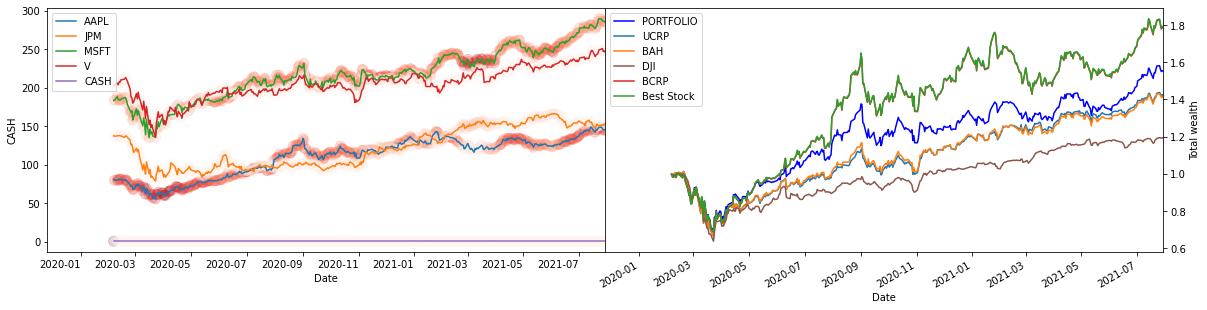

In [60]:
evalu8(agent, test_env)

In [49]:
agent_strategy = AgentStrategy(test_env.record.actions, name=MODEL.upper())

In [42]:
results, metrics = evaluate_baselines(test, agent_strategy)

DDPG.BAH.CRP.BCRP.UP.EG.Anticor.PAMR.OLMAR.RMR.CWMR.WMAMR.CORN.ONS.

In [43]:
metrics.sort_values('sharpe', ascending=False)

total_wealth profit_factor    sharpe annualized_return max_drawdown  \
BCRP        1.789556       1.18855  1.158635         47.886554    31.427266   
DDPG        1.552323       1.16497  0.990563         36.563383    30.403945   
CRP         1.419826      1.146566  0.852642         29.827194    34.332293   
EG          1.419373      1.146346  0.852032         29.805738    34.327305   
UP          1.418484      1.145833  0.850814         29.764328    34.295793   
ONS         1.429529      1.147327  0.847373         30.720743    34.631883   
BAH         1.411977      1.141778  0.839949         29.506246    34.231834   
Anticor     1.418631      1.120933  0.808704         30.965307    34.332293   
RMR         1.212772      1.061545   0.52466         21.109587    34.332293   
OLMAR       1.183073       1.05311  0.482841         19.459773    34.332293   
WMAMR       1.038245      1.010442  0.286478         13.326967    41.118134   
CORN        0.533001      0.812629 -0.900839        -34.974396    48.488216   
CWMR        0.448385      0.771513 -1.100518        -45.577128    55.049169   
PAMR        0.445866      0.769621 -1.110501        -45.966234     55.30161   

        drawdown_period information winning_pct annual_turnover  
BCRP         110.650355    0.792765   52.815013             0.0  
DDPG          97.691305    0.414969   54.010695       12.657078  
CRP          113.640905   -3.799032   54.278075        2.437476  
EG           113.640905   -3.072897   54.545455        2.313056  
UP           113.640905   -1.242656   54.545455        1.948611  
ONS          129.590506    0.011915   52.673797        8.750662  
BAH          113.640905   -0.353845   55.080214             0.0  
Anticor      103.672405    0.021648   52.673797       34.743598  
RMR          144.543257   -0.511768   51.871658       57.337781  
OLMAR        110.650355   -0.615833   50.802139       56.793544  
WMAMR        258.184162   -0.735712   51.336898       78.762103  
CORN         363.850267   -3.428915   41.666667      275.392238  
CWMR         371.825068    -3.67393   44.919786      354.091779  
PAMR         371.825068   -3.692322   44.652406      355.147766

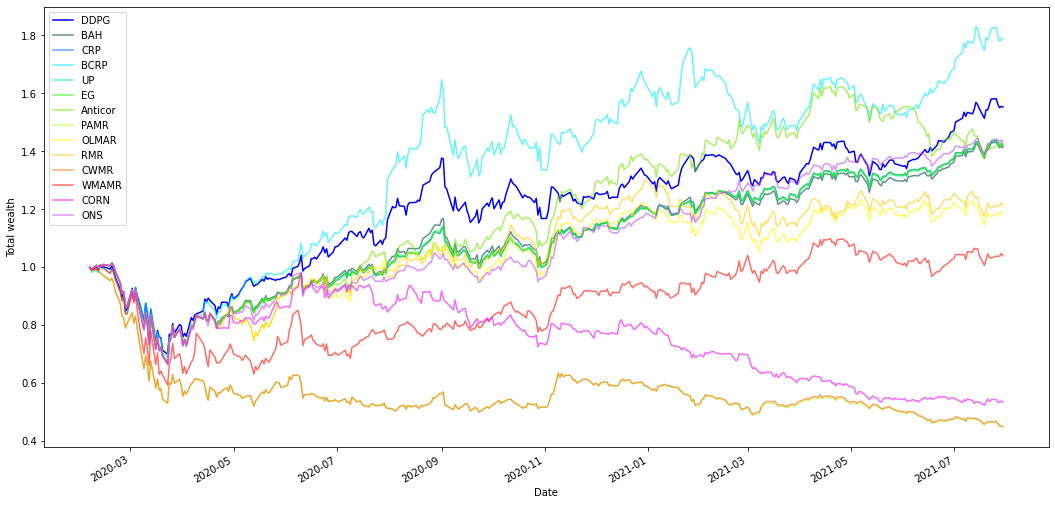

In [44]:
palette = sns.color_palette(palette='gist_ncar', n_colors=len(results))

ax = results[0].plot(assets=False, weights=False, ucrp=False, bah=False, portfolio_label='DDPG', color='blue')

for i, result in enumerate(results[1:]):
    name = results.index[i+1]
#     if name in ['CRP', 'UP', 'EG']:
    result.plot(assets=False, weights=False, ucrp=False, bah=False, 
                portfolio_label=name, ax=ax[0], color=palette[i], alpha=0.6)

#### Individual Plots

DDPG Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.99 ± 1.00
    Ulcer index: 4.26
    Information ratio (wrt UCRP): 0.41
    Appraisal ratio (CAPM): -0.97 ± 0.83
    Appraisal ratio (wrt UCRP): 0.48 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.97 / 6.988%
    Annualized return: 36.56%
    Annualized volatility: 36.91%
    Longest drawdown: 98 days
    Max drawdown: 30.40%
    Winning days: 54.0%
    Annual turnover: 12.7
        


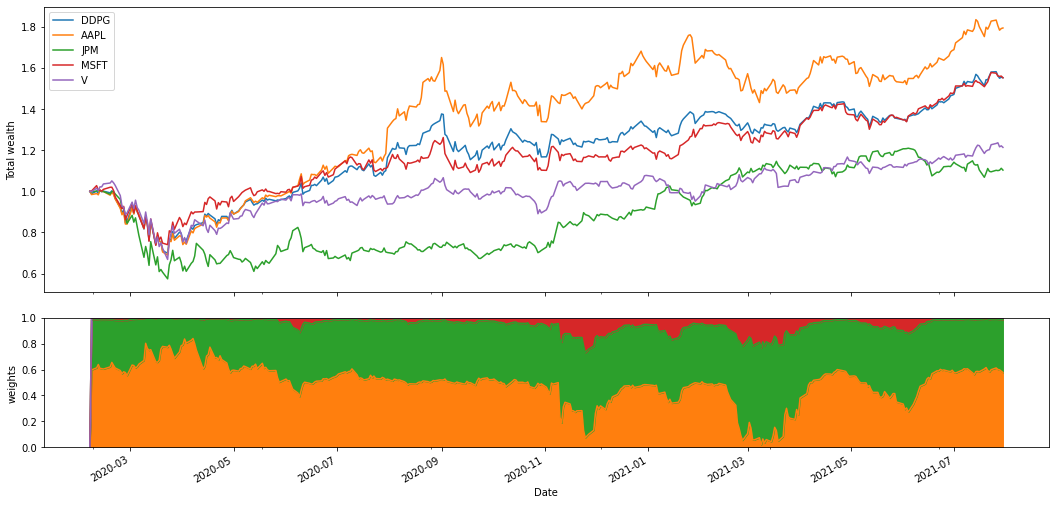

BAH Summary:
    Profit factor: 1.14
    Sharpe ratio: 0.84 ± 0.96
    Ulcer index: 3.26
    Information ratio (wrt UCRP): -0.35
    Appraisal ratio (CAPM): -2.47 ± 0.83
    Appraisal ratio (wrt UCRP): -0.29 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / -0.940%
    Annualized return: 29.51%
    Annualized volatility: 35.13%
    Longest drawdown: 114 days
    Max drawdown: 34.23%
    Winning days: 55.1%
    Annual turnover: 0.0
        


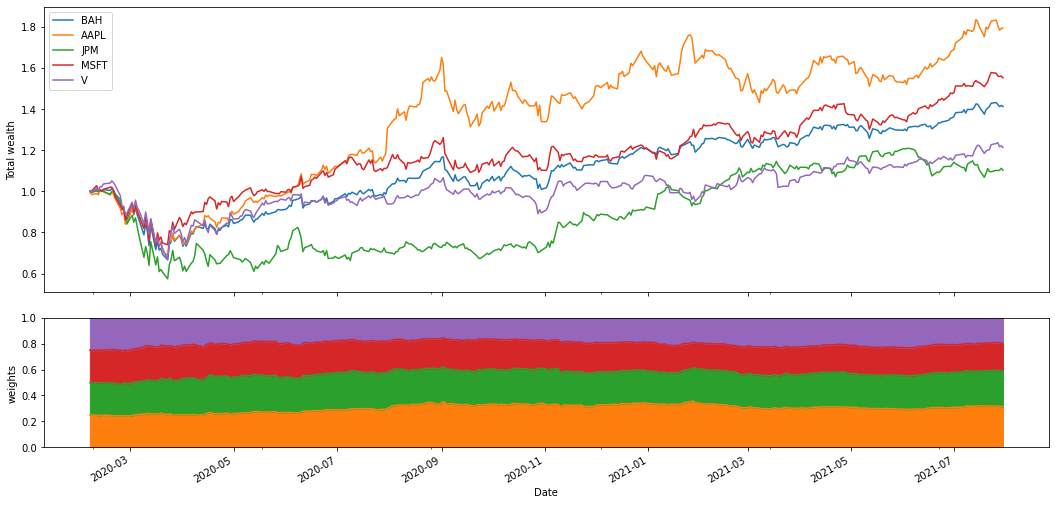

CRP Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.85 ± 0.96
    Ulcer index: 3.32
    Information ratio (wrt UCRP): -3.80
    Appraisal ratio (CAPM): -4.83 ± 0.83
    Appraisal ratio (wrt UCRP): -4.82 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / -0.610%
    Annualized return: 29.83%
    Annualized volatility: 34.98%
    Longest drawdown: 114 days
    Max drawdown: 34.33%
    Winning days: 54.3%
    Annual turnover: 2.4
        


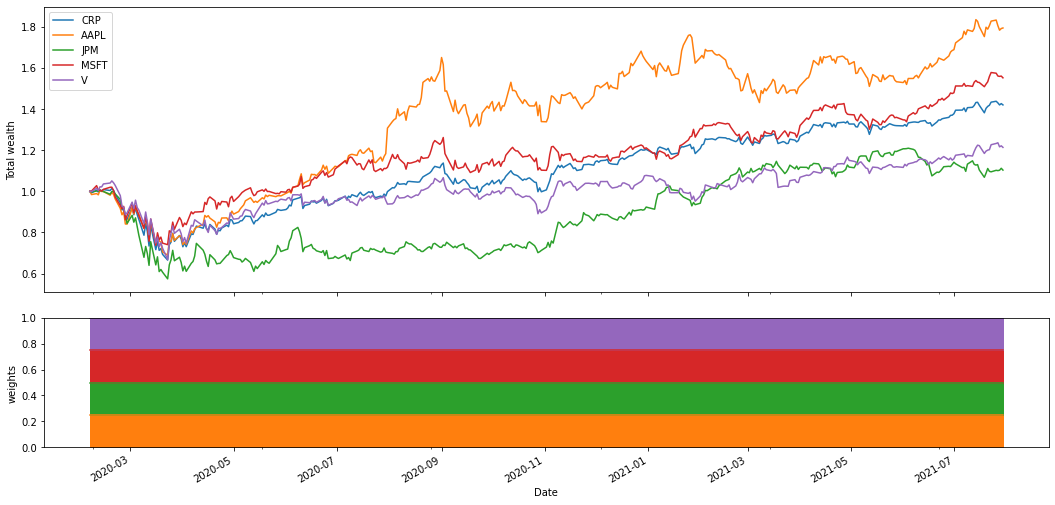

BCRP Summary:
    Profit factor: 1.19
    Sharpe ratio: 1.16 ± 1.06
    Ulcer index: 4.41
    Information ratio (wrt UCRP): 0.79
    Appraisal ratio (CAPM): 0.00 ± 1.05
    Appraisal ratio (wrt UCRP): 0.79 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / 17.380%
    Annualized return: 47.89%
    Annualized volatility: 41.33%
    Longest drawdown: 111 days
    Max drawdown: 31.43%
    Winning days: 52.8%
    Annual turnover: 0.0
        


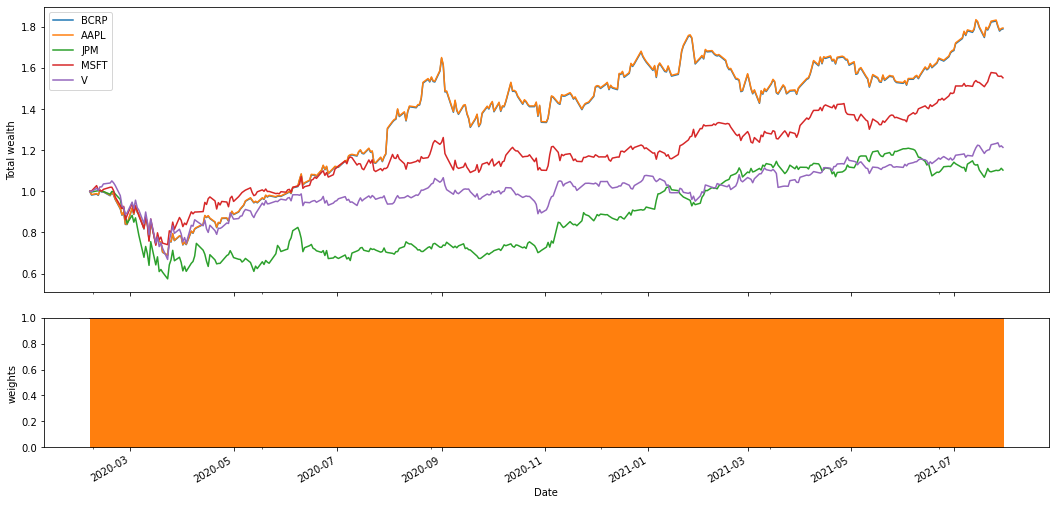

UP Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.85 ± 0.96
    Ulcer index: 3.31
    Information ratio (wrt UCRP): -1.24
    Appraisal ratio (CAPM): -3.24 ± 0.83
    Appraisal ratio (wrt UCRP): -0.89 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / -0.669%
    Annualized return: 29.76%
    Annualized volatility: 34.98%
    Longest drawdown: 114 days
    Max drawdown: 34.30%
    Winning days: 54.5%
    Annual turnover: 1.9
        


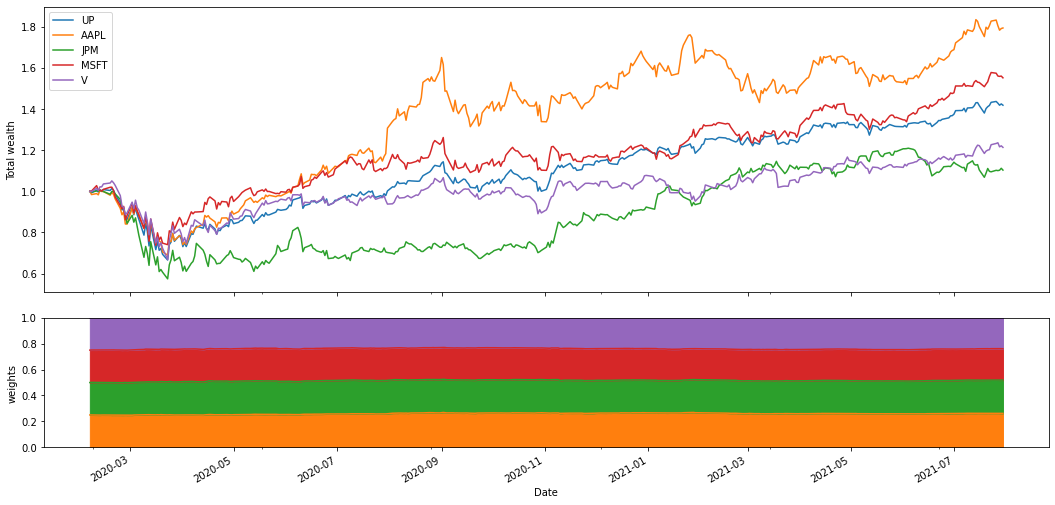

EG Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.85 ± 0.96
    Ulcer index: 3.32
    Information ratio (wrt UCRP): -3.07
    Appraisal ratio (CAPM): -4.27 ± 0.83
    Appraisal ratio (wrt UCRP): -2.39 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / -0.631%
    Annualized return: 29.81%
    Annualized volatility: 34.98%
    Longest drawdown: 114 days
    Max drawdown: 34.33%
    Winning days: 54.5%
    Annual turnover: 2.3
        


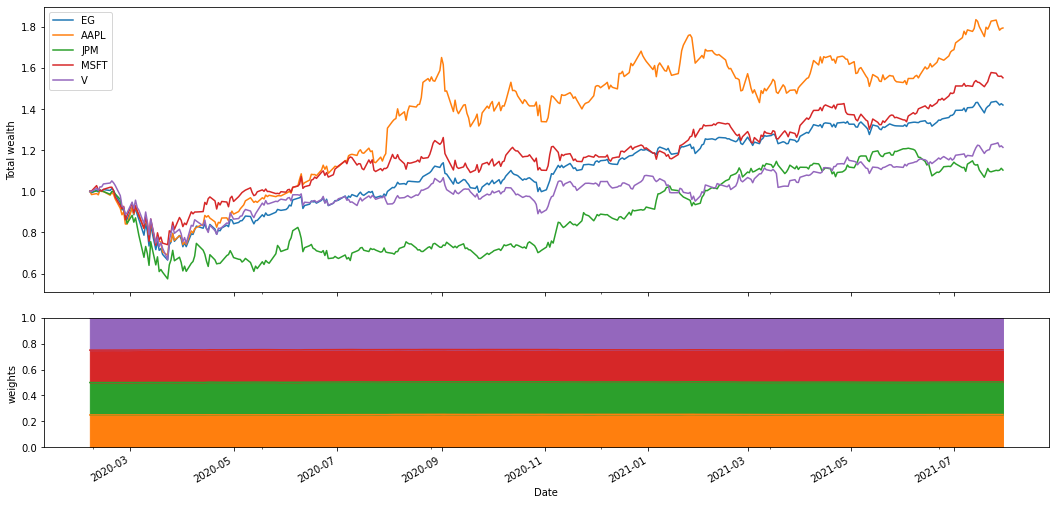

Anticor Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.81 ± 0.95
    Ulcer index: 3.24
    Information ratio (wrt UCRP): 0.02
    Appraisal ratio (CAPM): 0.15 ± 0.83
    Appraisal ratio (wrt UCRP): 0.06 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.99 / 0.925%
    Annualized return: 30.97%
    Annualized volatility: 38.29%
    Longest drawdown: 104 days
    Max drawdown: 34.33%
    Winning days: 52.7%
    Annual turnover: 34.7
        


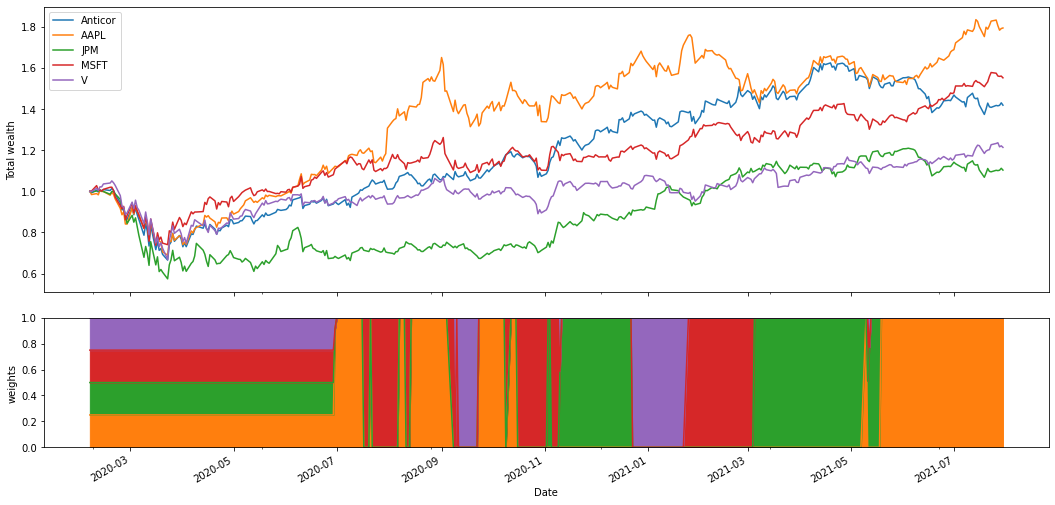

PAMR Summary:
    Profit factor: 0.77
    Sharpe ratio: -1.11 ± 1.05
    Ulcer index: -1.03
    Information ratio (wrt UCRP): -3.69
    Appraisal ratio (CAPM): -3.73 ± 0.83
    Appraisal ratio (wrt UCRP): -3.70 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.02 / -77.354%
    Annualized return: -45.97%
    Annualized volatility: 41.39%
    Longest drawdown: 372 days
    Max drawdown: 55.30%
    Winning days: 44.7%
    Annual turnover: 355.1
        


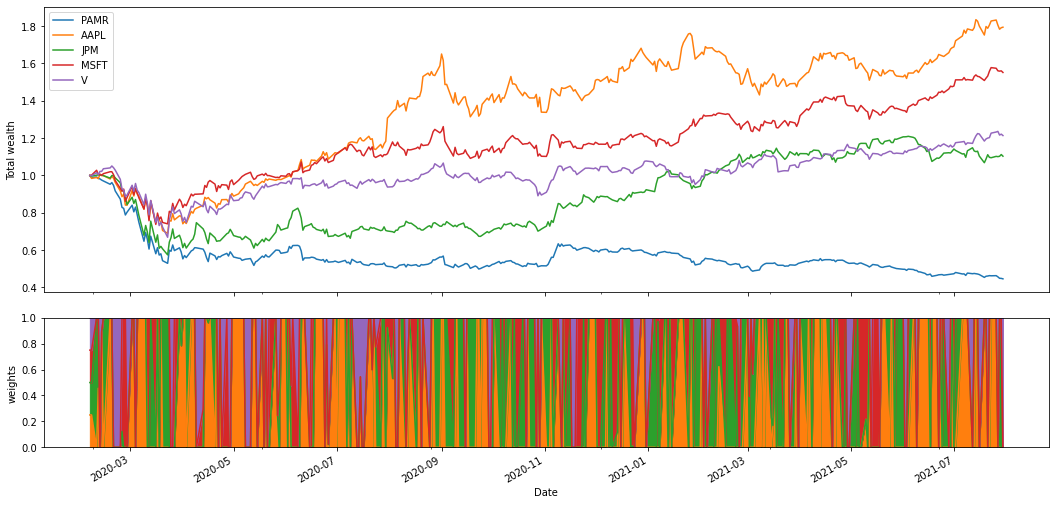

OLMAR Summary:
    Profit factor: 1.05
    Sharpe ratio: 0.48 ± 0.87
    Ulcer index: 1.89
    Information ratio (wrt UCRP): -0.62
    Appraisal ratio (CAPM): -0.56 ± 0.83
    Appraisal ratio (wrt UCRP): -0.65 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.03 / -11.920%
    Annualized return: 19.46%
    Annualized volatility: 40.30%
    Longest drawdown: 111 days
    Max drawdown: 34.33%
    Winning days: 50.8%
    Annual turnover: 56.8
        


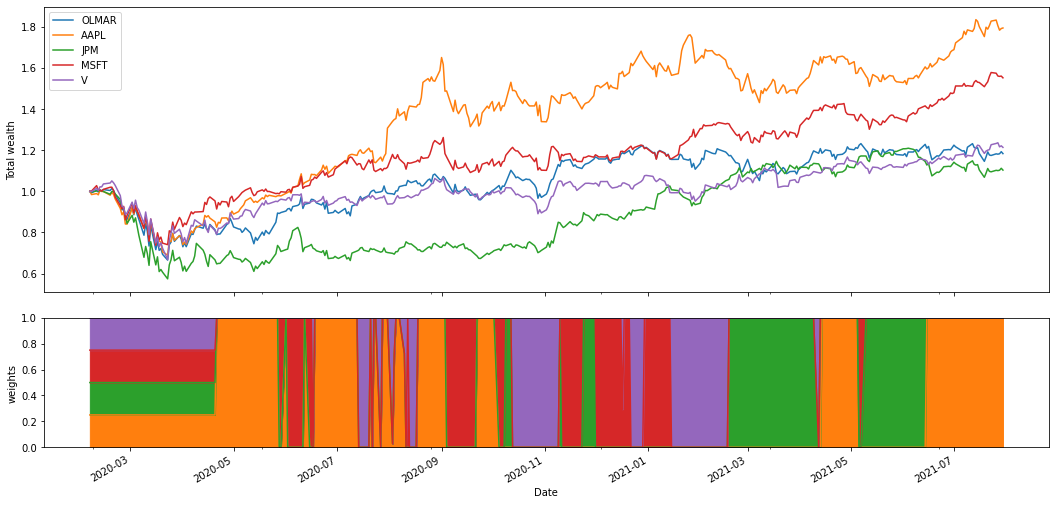

RMR Summary:
    Profit factor: 1.06
    Sharpe ratio: 0.52 ± 0.88
    Ulcer index: 2.01
    Information ratio (wrt UCRP): -0.51
    Appraisal ratio (CAPM): -0.43 ± 0.83
    Appraisal ratio (wrt UCRP): -0.53 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.02 / -9.987%
    Annualized return: 21.11%
    Annualized volatility: 40.23%
    Longest drawdown: 145 days
    Max drawdown: 34.33%
    Winning days: 51.9%
    Annual turnover: 57.3
        


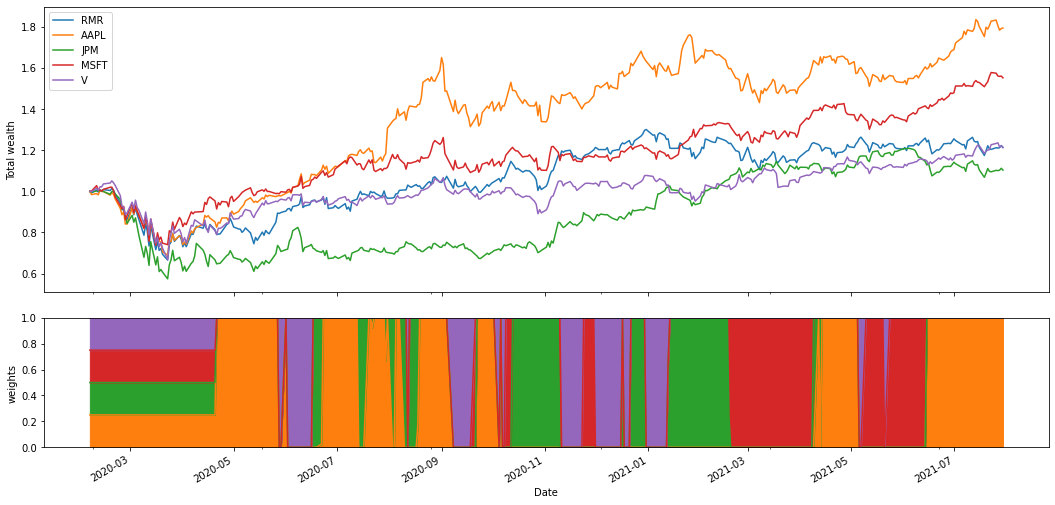

CWMR Summary:
    Profit factor: 0.77
    Sharpe ratio: -1.10 ± 1.04
    Ulcer index: -1.02
    Information ratio (wrt UCRP): -3.67
    Appraisal ratio (CAPM): -3.71 ± 0.83
    Appraisal ratio (wrt UCRP): -3.69 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.03 / -76.987%
    Annualized return: -45.58%
    Annualized volatility: 41.41%
    Longest drawdown: 372 days
    Max drawdown: 55.05%
    Winning days: 44.9%
    Annual turnover: 354.1
        


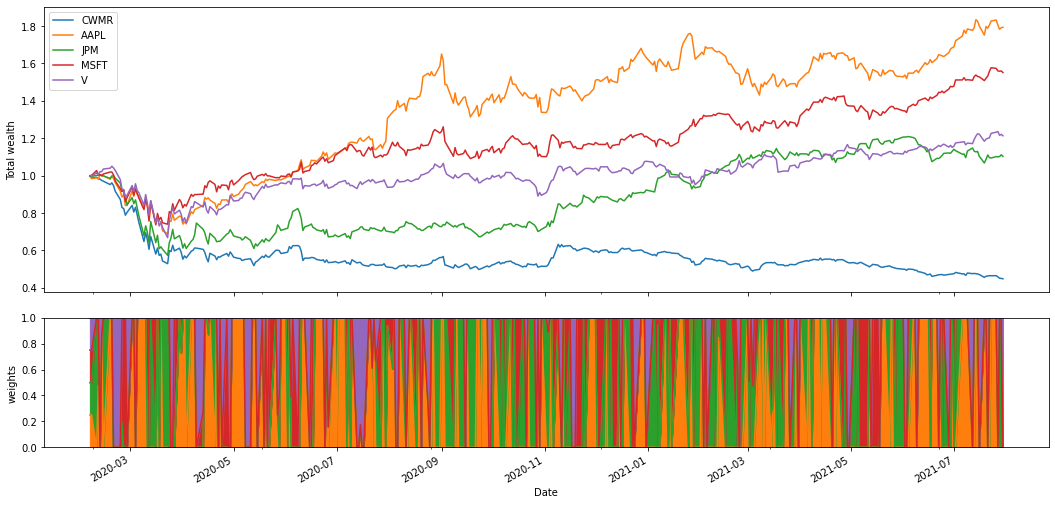

WMAMR Summary:
    Profit factor: 1.01
    Sharpe ratio: 0.29 ± 0.84
    Ulcer index: 0.73
    Information ratio (wrt UCRP): -0.74
    Appraisal ratio (CAPM): -0.79 ± 0.83
    Appraisal ratio (wrt UCRP): -0.96 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.16 / -22.029%
    Annualized return: 13.33%
    Annualized volatility: 46.52%
    Longest drawdown: 258 days
    Max drawdown: 41.12%
    Winning days: 51.3%
    Annual turnover: 78.8
        


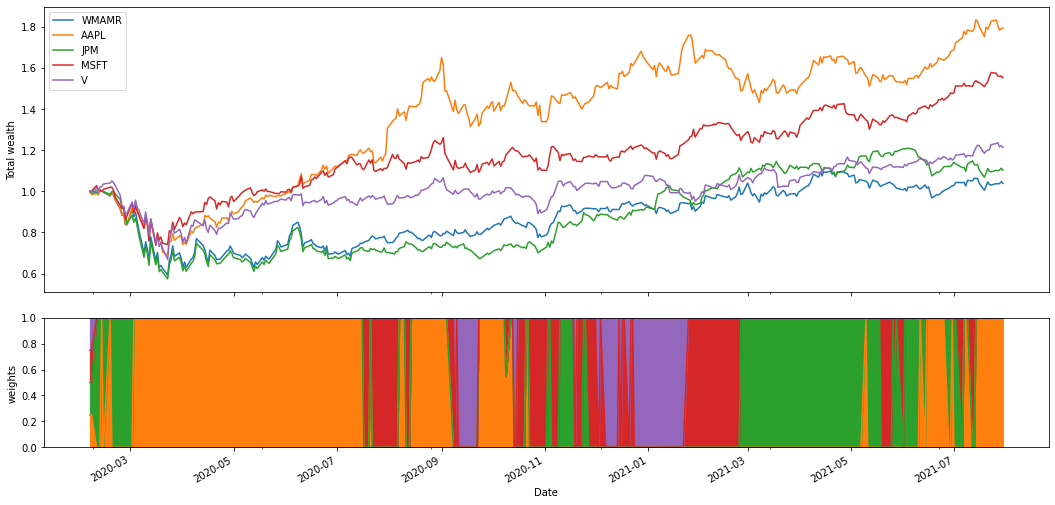

CORN Summary:
    Profit factor: 0.81
    Sharpe ratio: -0.90 ± 0.97
    Ulcer index: -1.21
    Information ratio (wrt UCRP): -3.43
    Appraisal ratio (CAPM): -3.53 ± 0.83
    Appraisal ratio (wrt UCRP): -3.35 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.97 / -64.555%
    Annualized return: -34.97%
    Annualized volatility: 38.82%
    Longest drawdown: 364 days
    Max drawdown: 48.49%
    Winning days: 41.7%
    Annual turnover: 275.4
        


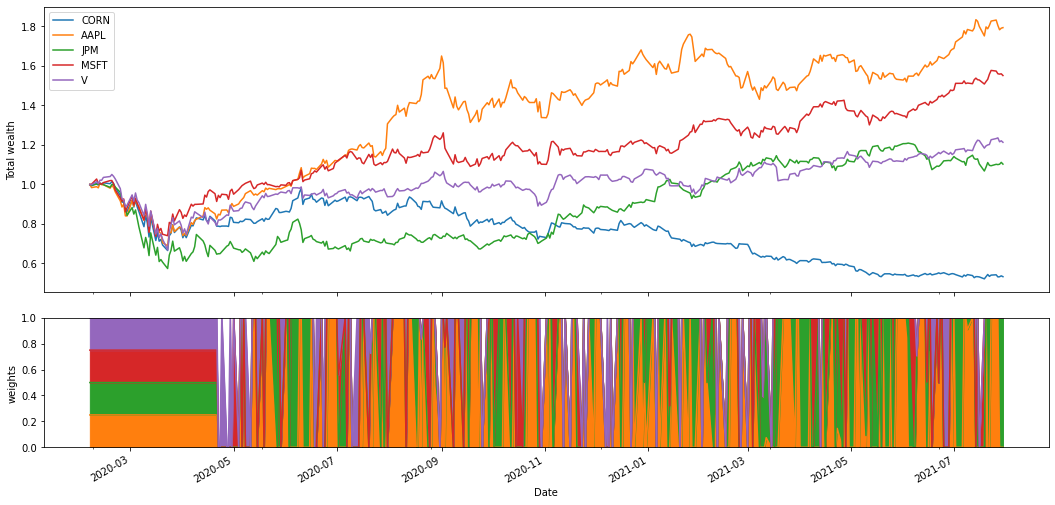

ONS Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.85 ± 0.96
    Ulcer index: 3.37
    Information ratio (wrt UCRP): 0.01
    Appraisal ratio (CAPM): 1.96 ± 0.83
    Appraisal ratio (wrt UCRP): 0.03 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.00 / 0.291%
    Annualized return: 30.72%
    Annualized volatility: 36.25%
    Longest drawdown: 130 days
    Max drawdown: 34.63%
    Winning days: 52.7%
    Annual turnover: 8.8
        


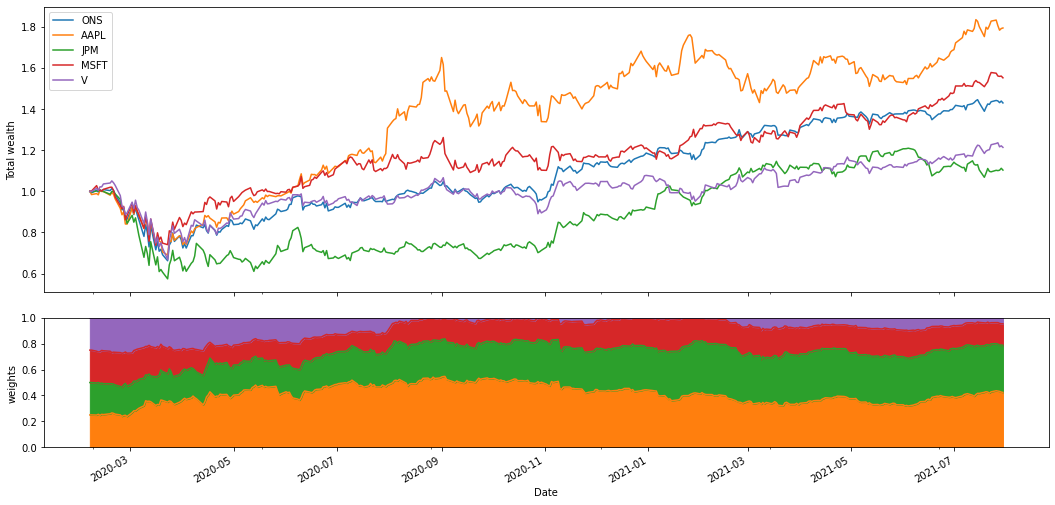

In [45]:
palette = sns.color_palette(n_colors=5)

for i, result in enumerate(results):
    name = results.index[i]
    print(name, result.summary())
    result.plot(assets=True, weights=True, ucrp=False, bah=False, portfolio_label=name, color=palette)
    plt.show()

#### Compare models

DDPG1_best_model.zip
lr: 1e-05 	gamma: 1 	batch_size: 64
{'n_critics': 1}


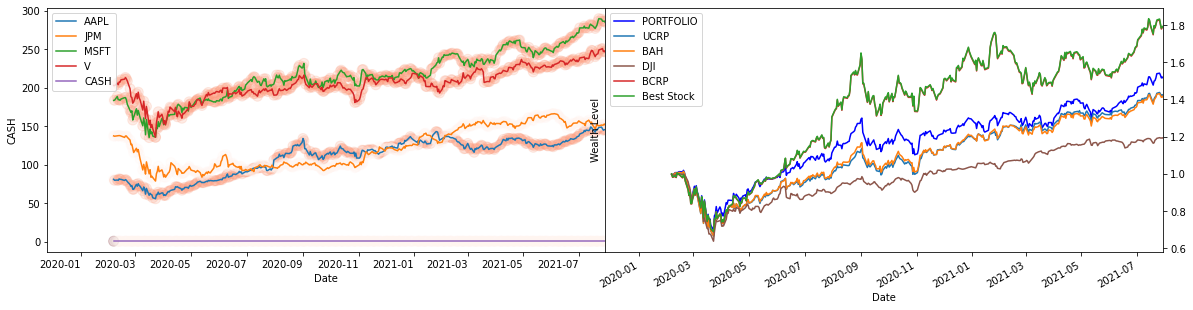

test2


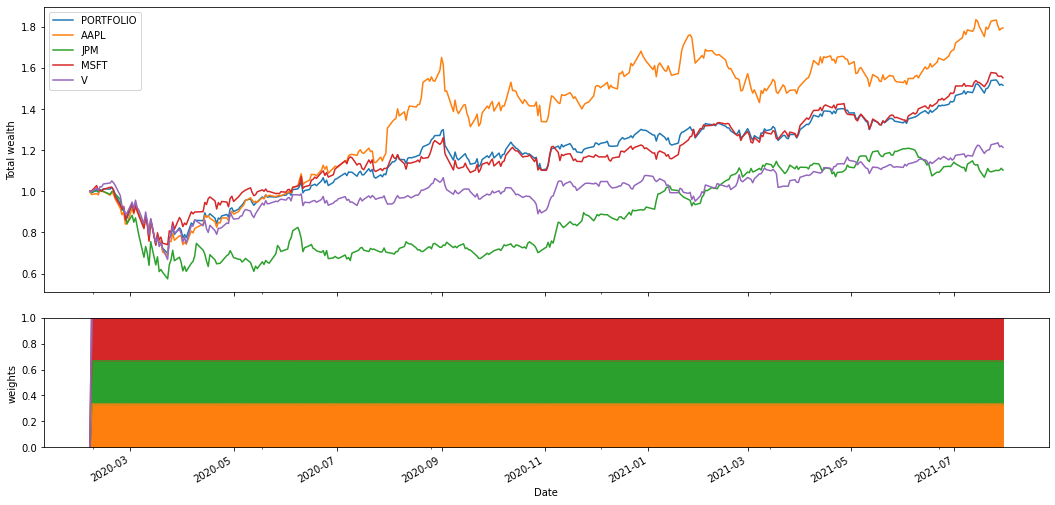

1.5154273756635104
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.97 ± 1.00
    Ulcer index: 4.29
    Information ratio (wrt UCRP): 0.41
    Appraisal ratio (CAPM): -3.67 ± 0.83
    Appraisal ratio (wrt UCRP): 0.50 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.98 / 4.677%
    Annualized return: 34.38%
    Annualized volatility: 35.38%
    Longest drawdown: 79 days
    Max drawdown: 31.50%
    Winning days: 57.0%
    Annual turnover: 2.5
        
----------------------------------------
DDPG2_best_model.zip
lr: 5e-06 	gamma: 0.5 	batch_size: 64
{'n_critics': 1}


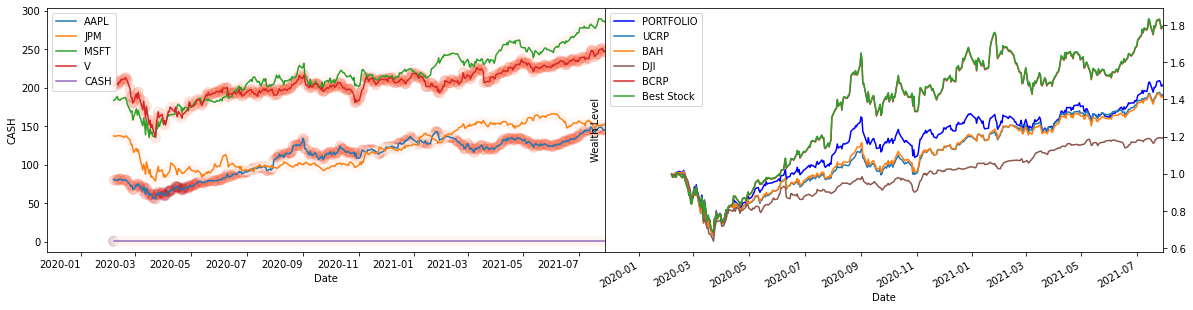

test2


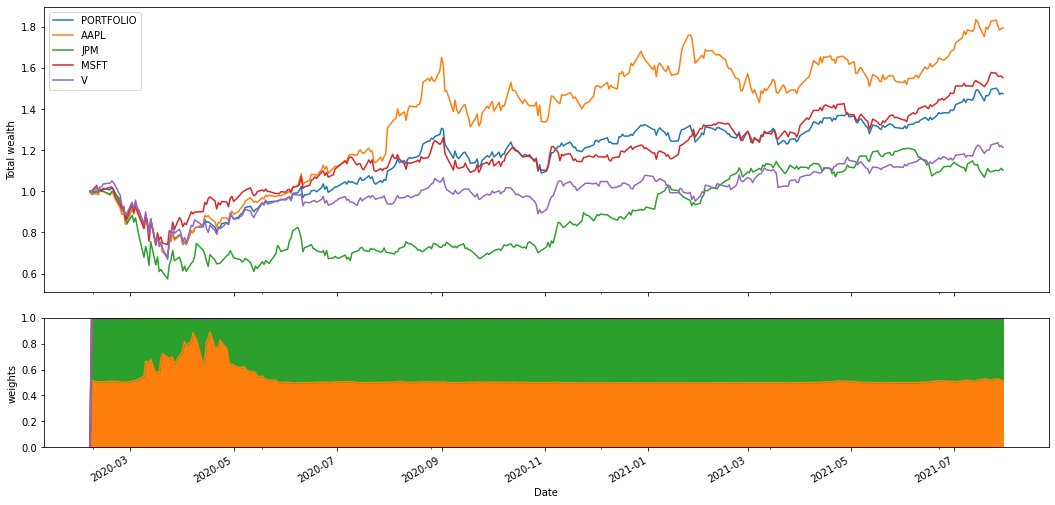

1.4739122888600384
Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.92 ± 0.98
    Ulcer index: 3.66
    Information ratio (wrt UCRP): 0.18
    Appraisal ratio (CAPM): -0.66 ± 0.83
    Appraisal ratio (wrt UCRP): 0.29 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.96 / 3.127%
    Annualized return: 32.48%
    Annualized volatility: 35.35%
    Longest drawdown: 80 days
    Max drawdown: 33.29%
    Winning days: 55.6%
    Annual turnover: 5.0
        
----------------------------------------
DDPG3_best_model.zip
lr: 5e-06 	gamma: 1 	batch_size: 64
{'n_critics': 1}


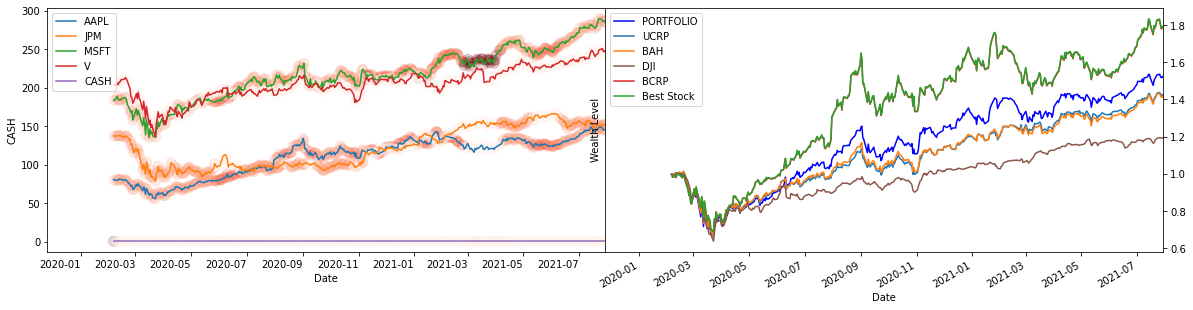

test2


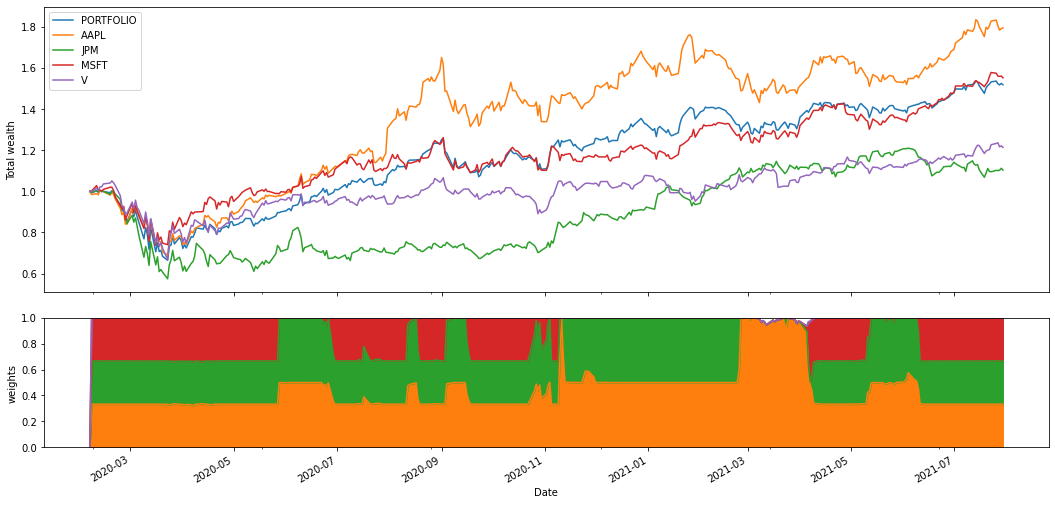

1.5181223096386938
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.95 ± 0.99
    Ulcer index: 3.78
    Information ratio (wrt UCRP): 0.46
    Appraisal ratio (CAPM): -0.27 ± 0.83
    Appraisal ratio (wrt UCRP): 0.40 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 1.02 / 3.993%
    Annualized return: 35.14%
    Annualized volatility: 37.15%
    Longest drawdown: 92 days
    Max drawdown: 33.76%
    Winning days: 55.3%
    Annual turnover: 12.6
        
----------------------------------------
DDPG4_test_best_model.zip
lr: 5e-06 	gamma: 1 	batch_size: 64
{'net_arch': [512, 256, 128], 'n_critics': 1}


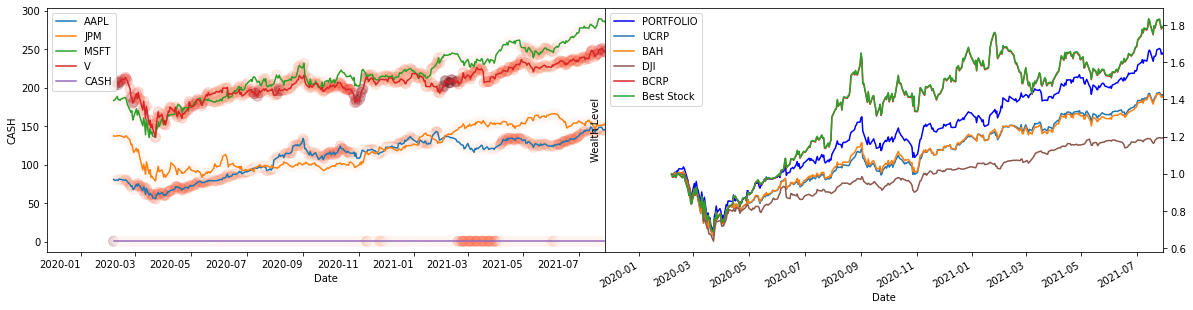

test1


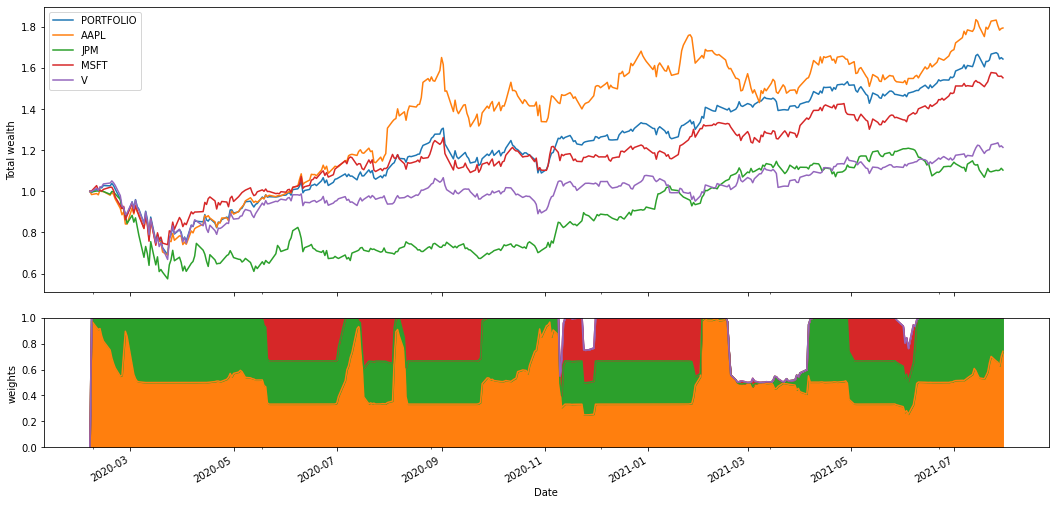

1.6429688154175643
Summary:
    Profit factor: 1.20
    Sharpe ratio: 1.13 ± 1.05
    Ulcer index: 4.71
    Information ratio (wrt UCRP): 0.92
    Appraisal ratio (CAPM): 1.46 ± 0.83
    Appraisal ratio (wrt UCRP): 1.03 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.97 / 10.362%
    Annualized return: 39.81%
    Annualized volatility: 35.31%
    Longest drawdown: 79 days
    Max drawdown: 33.43%
    Winning days: 55.9%
    Annual turnover: 15.2
        
----------------------------------------
DDPG5_best_model.zip
lr: 5e-06 	gamma: 1 	batch_size: 64
{'net_arch': [512, 256, 128], 'n_critics': 1}


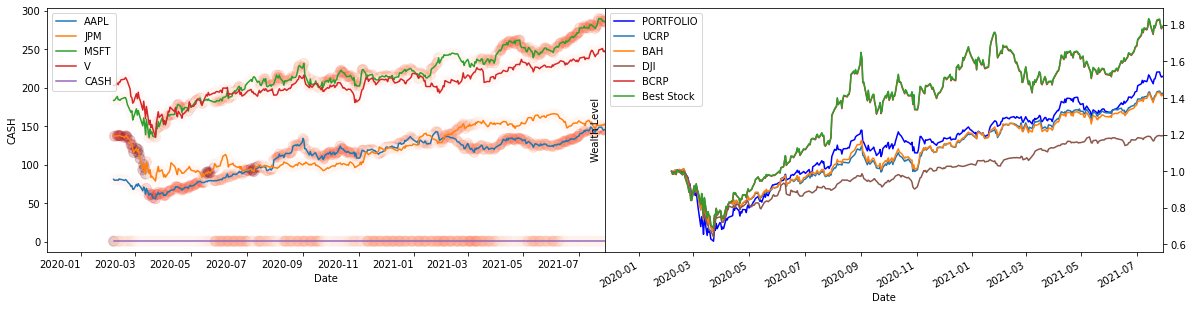

test1


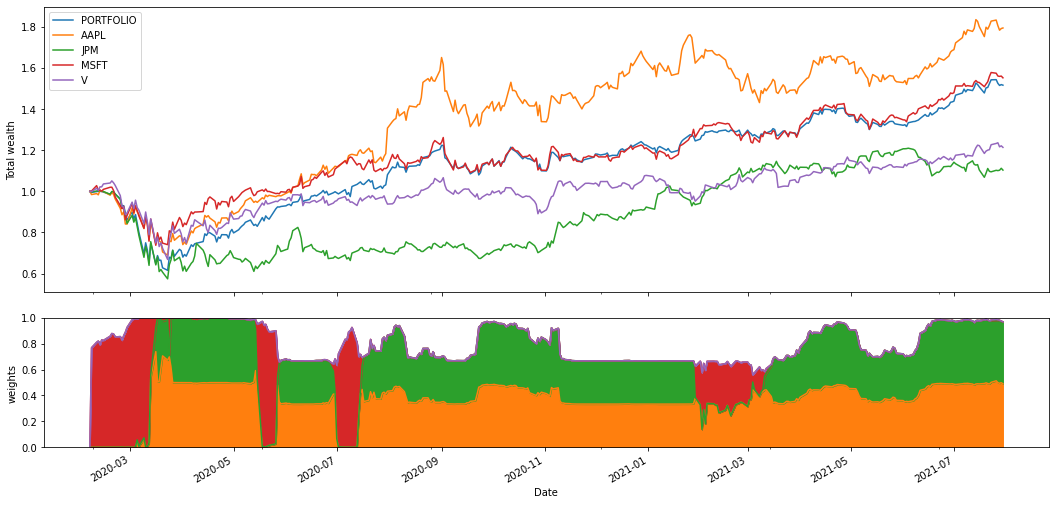

1.5158540001511986
Summary:
    Profit factor: 1.17
    Sharpe ratio: 0.96 ± 0.99
    Ulcer index: 3.38
    Information ratio (wrt UCRP): 0.27
    Appraisal ratio (CAPM): -0.12 ± 0.83
    Appraisal ratio (wrt UCRP): 0.39 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.94 / 6.073%
    Annualized return: 34.76%
    Annualized volatility: 36.37%
    Longest drawdown: 91 days
    Max drawdown: 38.41%
    Winning days: 53.5%
    Annual turnover: 15.2
        
----------------------------------------
DDPG6_best_model.zip
lr: 9e-06 	gamma: 1 	batch_size: 64
{'net_arch': [512, 256, 128], 'n_critics': 1}


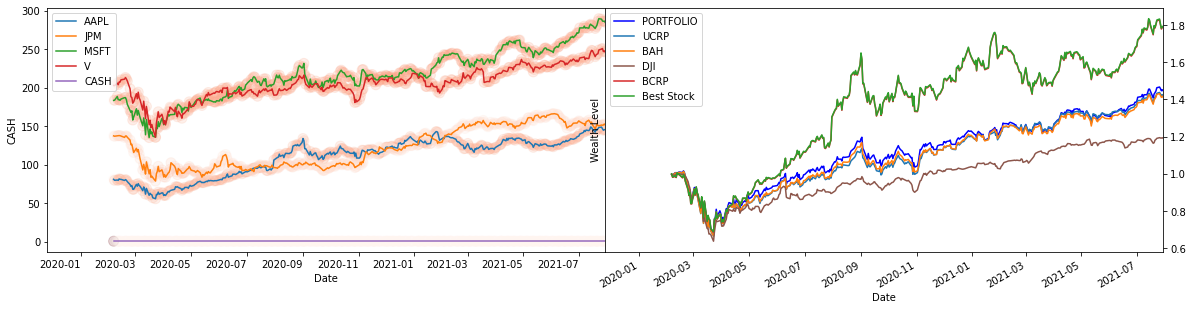

test1


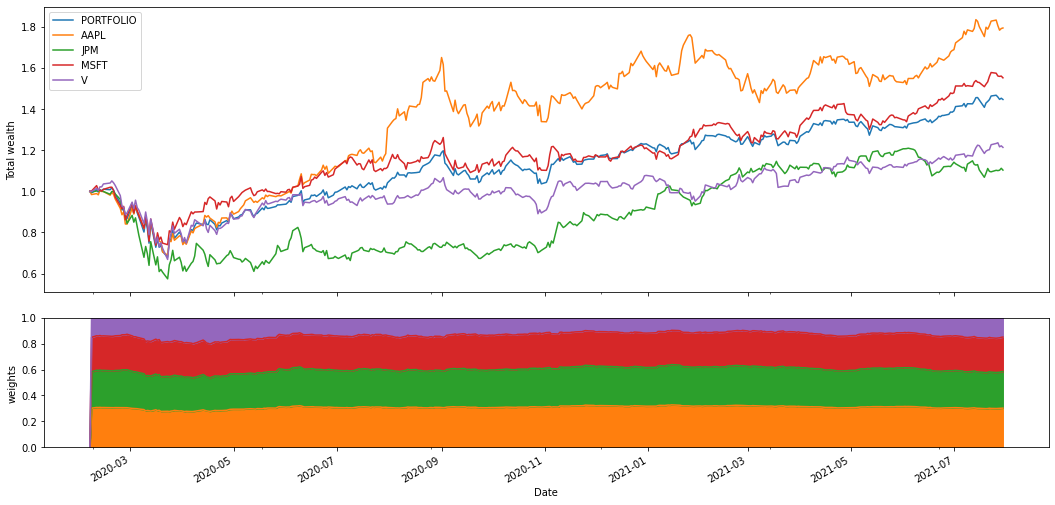

1.4463633414742911
Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.89 ± 0.97
    Ulcer index: 3.70
    Information ratio (wrt UCRP): 0.12
    Appraisal ratio (CAPM): -1.10 ± 0.83
    Appraisal ratio (wrt UCRP): 0.19 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.99 / 0.829%
    Annualized return: 31.10%
    Annualized volatility: 35.04%
    Longest drawdown: 94 days
    Max drawdown: 33.14%
    Winning days: 57.2%
    Annual turnover: 4.2
        
----------------------------------------
DDPG7_best_model.zip
(4, 4, 50)
(4, 4, 50)
lr: 2e-06 	gamma: 1 	batch_size: 64
{'features_extractor_class': <class '__main__.CustomNatureCNN'>, 'features_extractor_kwargs': {'features_dim': 69}, 'net_arch': [512, 256, 128], 'n_critics': 1}
(4, 4, 50)
Sequential(
  (0): Conv2d(4, 4, kernel_size=(1, 8), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(1, 16), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(1, 28), stride=(1, 1))
  (5): ReLU()
  (6): Flatten(start

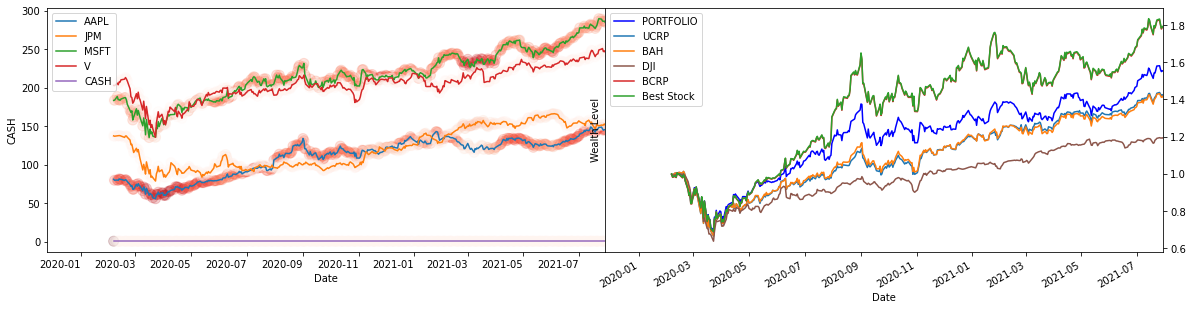

test1


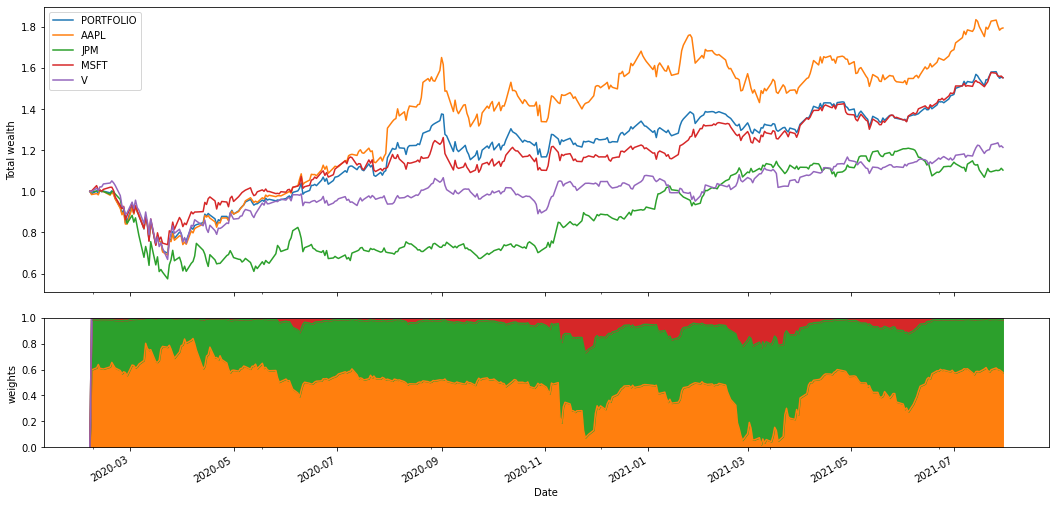

1.552322666577497
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.99 ± 1.00
    Ulcer index: 4.26
    Information ratio (wrt UCRP): 0.41
    Appraisal ratio (CAPM): -0.97 ± 0.83
    Appraisal ratio (wrt UCRP): 0.48 ± 0.82
    UCRP sharpe: 0.87 ± 0.97
    Beta / Alpha: 0.97 / 6.988%
    Annualized return: 36.56%
    Annualized volatility: 36.91%
    Longest drawdown: 98 days
    Max drawdown: 30.40%
    Winning days: 54.0%
    Annual turnover: 12.7
        
----------------------------------------


In [80]:
import os

PATH = 'models/'
palette = sns.color_palette(n_colors=5)

for file in os.listdir(PATH):
    if file.startswith('DDPG'):
        m = DDPG
    elif file.startswith('DQN'):
        m = DQN
    
    print(file)
    agent = m.load(PATH+file)

    print('lr:', agent.learning_rate, '\tgamma:', agent.gamma, '\tbatch_size:', agent.batch_size)
    print(agent.policy_kwargs)
    if 'features_extractor_class' in agent.policy_kwargs:
        x = agent.policy_kwargs['features_extractor_class'](test_env.observation_space)
        print(x.cnn)

    try:
        evalu8(agent, test_env)
        tenv = test_env
        print('test1')
    except:
        evalu8(agent, test_env2)
        tenv = test_env2
        print('test2')

    agent_strategy = AgentStrategy(tenv.record.actions, name=MODEL.upper()).run(test['Close'][49:])
    agent_strategy.fee = config.COMMISSION_RATE
    agent_strategy.plot(assets=True, weights=True, color=palette)
    plt.show()
    print(agent_strategy.total_wealth)
    print(agent_strategy.summary())
    print('-'*40)